<a href="https://colab.research.google.com/github/hochthom/OG-AI4Artists-2023/blob/main/Image-Generation/ai4artists_stable_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stable Diffusion** 🎨 
*...using `🧨diffusers`*

This Colab notebook shows how to use Stable Diffusion with the 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). 

Let's get started!

In [ ]:
!nvidia-smi

Wed Apr 19 13:55:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Next, you should install `diffusers` as well `scipy`, `ftfy` and `transformers`. `accelerate` is used to achieve much faster loading.

In [ ]:
!pip install diffusers
!pip install transformers scipy ftfy accelerate safetensors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.0/852.0 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.8 MB/s eta 0:00:00


### Stable Diffusion Pipeline



In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from diffusers import StableDiffusionPipeline

#MODEL = "stabilityai/stable-diffusion-2-1"       # 768 x 768
MODEL = "dreamlike-art/dreamlike-photoreal-2.0"   # 768 x 768

pipe = StableDiffusionPipeline.from_pretrained(MODEL, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/safetensors/torch.py:99: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(filename, framework="pt", device=device) as f:
/usr/local/lib/python3.9/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/usr/local/lib/python3.9/dist-packages/torch/storage.py:899: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This shoul

And we are ready to generate images:

## 2. Creating Images

  0%|          | 0/50 [00:00<?, ?it/s]

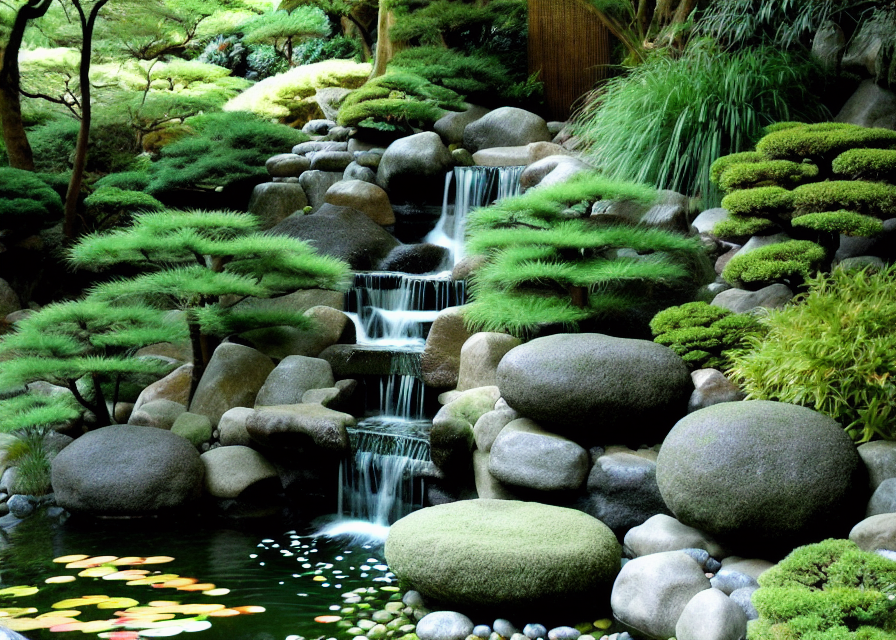

In [ ]:
import torch
generator = torch.Generator("cuda").manual_seed(24)

prompt = "photo, dreamy japanese zen garden with waterfall and pond, beautiful lighting"
neg = 'house, roof, window, brown, wood'

image = pipe(prompt, height=640, width=896, negative_prompt=neg, num_inference_steps=50, generator=generator).images[0]

# if you're in a google colab you can directly display it with 
image

# Upscaling

In [ ]:
from transformers import AutoImageProcessor, Swin2SRForImageSuperResolution

processor = AutoImageProcessor.from_pretrained("caidas/swin2SR-classical-sr-x2-64")
model = Swin2SRForImageSuperResolution.from_pretrained("caidas/swin2SR-classical-sr-x2-64")


In [ ]:
# prepare image for the model
inputs = processor(image, return_tensors="pt")

# forward pass
with torch.no_grad():
    outputs = model(**inputs)

output = outputs.reconstruction.data.squeeze().float().cpu().clamp_(0, 1).numpy()
output = np.moveaxis(output, source=0, destination=-1)

output = (output * 255.0).round().astype(np.uint8)  # float32 to uint8
image2x = Image.fromarray(output)

In [ ]:
image2x.size

(1808, 1296)

# Saving

In [ ]:
DATA_DIR = '.'

with open(os.path.join(DATA_DIR, id + '_prompt.txt'), 'w') as f:
    f.write('Prompt: %s\n' % prompt)
    f.write('Negative: %s\n' % str(neg))

id = str(hash(prompt + str(neg)))[1:13]
image.save(os.path.join(DATA_DIR, id + '_image.png'))

# Cheatsheet

### Adjectives:
adorable, aggressive, alien, ancient, angelic, angry, anxious, athletic, award-winning, basic, beautiful, chaotic, cheerful, clean, cold, colorful, confusing, cozy, creepy, cute, depressing, detailed, dirty, disgusting, dreamy, dry, ecstatic, elderly, ethereal, evil, excited, expensive, fancy, fat, flat, fluffy, friendly, furry, fuzzy, gloomy, good, gorgeous, greeble, hairy, handsome, happy, healthy, huge, hyperrealistic, impossible, incoherent, intricate, joyful, large, lonely, lucid, luminous, massive, mature, mellow, micro, mini, minimalist, moody, morbid, mottled, muted, nano, nervous, old, old-fashioned, ornate, otherworldly, outstanding, photorealistic, plain, powerful, pretty, priceless, psychedelic, quiet, rainy, realistic, refreshing, sad, simple, sinister, sleepy, smooth, spooky, strong, talented,tame, tasty, tense, terrible, thankful, thoughtful, thoughtless, tired, tough, troubled, ugly, uninterested, unusual, upset, uptight, vast, victorious, vivacious, weary, wicked, wild, witty, worrisome, zany, zealous

### Lighting: 
accent lighting, afternoon, artifical lighting, backlighting, beautiful lighting, blue hour, bright lighting, lit by candlelight, Christmas lights, cinematic lighting, colorful lighting, contre-jour, crepuscular rays, dark lighting, dawn, daylight, daytime, dim lighting, dramatic lighting, dusk, evening, film noir lighting, lit by firelight, flickering light, floodlight, fluorescent light, front lighting, global illumination, golden hour, halfrear lighting, halogen light, hard lighting, high key lighting, incandescent light, low key lighting, low lighting, moody lighting, morning, natural lighting, nighttime, noon, portrait lighting, ray tracing, ray tracing global illumination, rays of light, rays of shimmering light, realistic lighting, Rembrandt lighting, rim lighting, silhouette lighting, soft lighting, split lighting, spotlight, studio lighting, sunlight, sunrise, sunset, twilight, ultraviolet light, volumetric lighting, Xray

### Time periods: 
ancient Egypt, ancient Greece, ancient Rome, antique, Assyrian Empire, Aztec, Babylonian Empire, Benin Kingdom, Bronze Age, Byzantine Empire, Carolingian, Dark Ages, Edwardian, Elizabethan, Georgian, Gilded Age, Great Depression, Heian Period, Incan, Industrial Revolution, Iron Age, Maori, Mayan, medieval, Meiji Period, midcentury, Middle Ages, Ming Dynasty, Minoan, modern, Moorish, Mughal Era, Nasrid, Navajo, Neolithic, Olmec, Ottoman Empire, Paleolithic, Persian Empire, pre-Columbian, prehistoric, Qing Dynasty, Regency, Renaissance, retro, Shang Dynasty, Songhai, Stone Age, Sumerian, Tokugawa Shogunate, Tudor, Victorian, Viking, World War I, World War II, Zhou Dynasty, Zuni-Pueblo, 1100s, etc.

### Decorative Art: 
3D print, amigurumi, applique, balloon modelling, balloon twisting, bas-relief, beadwork, blown glass, bone china, carved, carved ivory, carved lacquer, carving, chip-carving, claymation, cloisonne, crochet, cross stitch, diorama, embroidery, enameling, felting, fretwork, glass mosaic, ice-carving, impressionist mosaic, inlaid, intarsia, jigsaw puzzle, crochet, lacquer, lampwork, latte art, leather carving, leatherwork, marble, marquetry, micromosaic, miniature painting, modular origami, mosaic, needlework, origami, paper model, papercutting, papier-mache, photographic mosaic, Pietra dura, porcelain, pottery, puppet, puzzle, pysanky, quillwork, quilted, relief-carving, repousse, rigid origami, sand art, scrimshaw, sculpture, stained glass, statue, string-art, tapestry, tattoo, tattoo art, Venetian glass, weaving, wet-folding, whittling, wood-burning

### Rendering techniques: 
3D model, 3ds Max, 500px, Arnold render, ArtStation, Blender Render, CGsociety, Cinema4D Render, CryEngine, Cycles Render, Daz 3D, DeviantArt, DirectX Render, Doughy Render, Houdini Render, Infini-D Render, KitBash3D, Luxcore Render, Marvelous Designer, MentalRay Render, OctaneRender, Optix Render, Photobashed, Photoshop, physically based render, Pixia, Quixel Megascans, Raylectron Render, Redshift Render, Sketchfab, Substance 3D, Terragen, Unreal Engine, Vray Render, Weta Digital, Zbrush Render

### Photography Styles: 
daguerreotype, tintype, film negative, Tri-X, Kodachrome, slide film, portra 800, Natura 1600, ilford delta 3200, polaroid, hasselblad, double exposure, multiple exposure, large format camera, wide angle lens, fisheye lens, tilt shift lens, anamorphic, lensbaby, telephoto, prime lens, f1.8, f2.8, f4, f11, f16, photoshoot, commercial, thermographic, x-ray, infrared

### Print Styles: 
Advertisement, Aquatint, Banner, Barcode, Block printing, Blueprint, Booklet, Business card, Collage, Coloring book, Comic book, Cyanotype, Election photo, Election poster, Etching, Graphic novel, Halftone, illuminated manuscript, illustrated-booklet, instruction manual, intaglio, Iinocut, Lithograph, Logo, Magazine, “Magic the Gathering” card, Manuscript, Map, Mezzotint, Mono printing, Movie poster, Newspaper, Newsprint, Photocollage, Photograph, Postage stamp, Poster, Product photo, Propaganda Poster, QR code, Schematic, Signage, Silver gelatin, Sticker, Storyboard, Storybook illustration, Tarot card, Visual novel, Wall decal, Woodblock print.

### Art styles: 
Abstract, Abstract expressionism, Academism, Action painting, American realism, Analytical cubism, Anime, Art Deco, Art Nouveau, Baroque, Bauhaus, Biopunk, Color Field painting, Classical realism, Conceptual art, Cubism, Cybernoir, Cyberpunk, Dada, Dark fantasy, De Stijl, Decopunk, Dieselpunk, Digital art, Expressionism, Fauvism, Futurism, Fine art, Futurism, Gothic, Impressionism, Installation art, Land art, Lyrical Abstraction, Manga, Modern art, Minimalism, Modernism, Neo-Dada, Neo-expressionism, Neoclassical, Neo-Impressionism, New realism, Nouveau Realisme, Op Art, Orphism, Photorealism, Pixel art,  Pop art, Post-Impressionism, Post-minimalism, Post-painterly abstraction, Precisionism, Purism, Realism, Rococo, Romanticism, Socialist realism, Steampunk, Surrealism, Synthwave, Surrealism, Symbolism, Synchromism, Tonalism, Ukiyo-e, Video art, and Zouave.